#Introduction#
This code use LIME (local interpretable model-agnostic explanations) to explain the COVID-19 prediction results. 

This file is tested under google colab. To reproduce the result, you will need to prepare the dataset, model file and config.yml file correctly.

# Preparing updated covid-cxr #

This project is based on the previous work from https://github.com/aildnont/covid-cxr. However, the original code is developed under windows which do not work on a Mac. It also cannot run in the python environment other than version 3.6. It only works with tensorflow_gpu and etc.

I fixed most of the issues and did the following work for our project:
1. Preprocess the data and generate train, test, validation, and store this information in three separate files (covid-cxr/data/processed/train_set.csv, covid-cxr/data/processed/test_set.csv, covid-cxr/data/processed/val_set.csv);
2. Modify the config.yml which defines the parameters;
3. Store all the images files which used to predict;
4. Generate the model files and store them in the following directory (covid-cxr/results/models).


To make it easy, I shared all codes, data, and models with the public, and you can access them through the below link.
https://drive.google.com/drive/folders/1wyvVPx9TvArGIldJkDpQfLRufwKZOTKQ?usp=sharing

You have two ways to use it:
1. The fast way to use it is as below:
Step 1. Login to your google drive and paste the above link to your browser;
Step 2. Right-click the folder name *covid-cxr* and click *Add shortcut to Drive*. Now, if you connect your google drive in colab, you will see the covid-cxr directory has been linked in your home.

The code connects your google drive in colab environment:

```
from google.colab import drive
drive.mount('/content/drive')
```

2. You can also choose to download the whole directory as a zip file, and upload it to your google colab directory. Since it is huge (3GB), it could be slow.

# Install necessary libraries#
This program requires installing specific version of libraries. In google colab, please run the below command. Please ignore the warning message since I have to use the specific version of scikit-image.


```
# !pip install scikit-image==0.19.2
# !pip install lime==0.1.1.37
```



In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install scikit-image==0.19.2

     |████████████████████████████████| 13.5 MB 15.8 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
!pip install lime==0.1.1.37

     |████████████████████████████████| 275 kB 14.9 MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-py3-none-any.whl size=284290 sha256=cb12cd6edfce290859dc4685040f3a5704bf0d3b80fe865082abd95db151fcbd
  Stored in directory: /root/.cache/pip/wheels/5d/7a/8d/30e0ea15164fb80d5484e83ab991e188d6a9d8febfada307a6
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=9df31b9cf02074cf12c243742b3edd5f86b7aa0cdc5f85835f0322d2f318df53
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built lime progressbar


# Import libraries #

In [4]:
from lime.lime_image import *
import pandas as pd
import yaml
import os
import datetime
import dill
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Define functions that will be used in the main program
This following cell was refined version in order to run on Google colab. The original code can be found by the following link: https://github.com/aildnont/covid-cxr.

In [5]:
def visualize_explanation(orig_img, explanation, img_filename, label, probs, class_names, label_to_see='top', dir_path=None):
    '''
    Visualize an explanation for the prediction of a single X-ray image.
    :param orig_img: Original X-Ray image
    :param explanation: ImageExplanation object
    :param img_filename: Filename of the image explained
    :param label: Ground truth class of the example
    :param probs: Prediction probabilities
    :param class_names: Ordered list of class names
    :param label_to_see: Label to visualize in explanation
    :param dir_path: Path to directory where to save the generated image
    :return: Path to saved image
    '''

    # Plot original image on the left
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(orig_img)

    # Plot the image and its explanation on the right
    if label_to_see == 'top':
        label_to_see = explanation.top_labels[0]
    explanation.image = orig_img
    temp, mask = explanation.get_image_and_mask(label_to_see, positive_only=False, num_features=10,
                                                hide_rest=False)
    ax[1].imshow(mark_boundaries(temp, mask))

    # Display some information about the example
    pred_class = np.argmax(probs)
    fig.text(0.02, 0.8, "Prediction probabilities: " + str(['{:.2f}'.format(probs[i]) for i in range(len(probs))]),
             fontsize=10)
    fig.text(0.02, 0.82, "Predicted Class: " + str(pred_class) + ' (' + class_names[pred_class] + ')', fontsize=10)
    if label is not None:
        fig.text(0.02, 0.84, "Ground Truth Class: " + str(label) + ' (' + class_names[label] + ')', fontsize=10)
    fig.suptitle("LIME Explanation for image " + img_filename, fontsize=13)
    fig.tight_layout()
    fig.show()

    # Save the image
    filename = None
    if dir_path is not None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        filename = dir_path + img_filename.split('/')[-1] + '_exp_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.png'
        plt.savefig(filename)
    return filename

def predict_instance(x, model):
    '''
    Runs model prediction on 1 or more input images.
    :param x: Image(s) to predict
    :param model: A Keras model
    :return: A numpy array comprising a list of class probabilities for each prediction
    '''
    y = model.predict(x)  # Run prediction on the perturbations
    if y.shape[1] == 1:
        probs = np.concatenate([1.0 - y, y], axis=1)  # Compute class probabilities from the output of the model
    else:
        probs = y
    return probs

def predict_and_explain(x, model, exp, num_features, num_samples):
    '''
    Use the model to predict a single example and apply LIME to generate an explanation.
    :param x: Preprocessed image to predict
    :param model: The trained neural network model
    :param exp: A LimeImageExplainer object
    :param num_features: # of features to use in explanation
    :param num_samples: # of times to perturb the example to be explained
    :return: The LIME explainer for the instance
    '''

    def predict(x):
        '''
        Helper function for LIME explainer. Runs model prediction on perturbations of the example.
        :param x: List of perturbed examples from an example
        :return: A numpy array constituting a list of class probabilities for each predicted perturbation
        '''
        probs = predict_instance(x, model)
        return probs

    # Algorithm for superpixel segmentation. Parameters set to limit size of superpixels and promote border smoothness
    segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=2.25, max_dist=50, ratio=0.1, sigma=0.15)

    # Generate explanation for the example
    explanation = exp.explain_instance(x, predict, num_features=num_features, num_samples=num_samples, segmentation_fn=segmentation_fn)
    probs = predict_instance(np.expand_dims(x, axis=0), model)
    return explanation, probs

def remove_text(img):
    '''
    Attempts to remove bright textual artifacts from X-ray images. For example, many images indicate the right side of
    the body with a white 'R'. Works only for very bright text.
    :param img: Numpy array of image
    :return: Array of image with (ideally) any characters removed and inpainted
    '''
    mask = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)[1][:, :, 0].astype(np.uint8)
    img = img.astype(np.uint8)
    result = cv2.inpaint(img, mask, 10, cv2.INPAINT_NS).astype(np.float32)
    return result

def setup_lime():
    '''
    Load relevant information and create a LIME Explainer
    :return: dict containing important information and objects for explanation experiments
    '''

    # Load relevant constants from project config file
    #cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))
    cfg = yaml.safe_load(open(Path(covid_cxr) / 'config.yml', 'r'))    
    lime_dict = {}
    lime_dict['NUM_SAMPLES'] = cfg['LIME']['NUM_SAMPLES']
    lime_dict['NUM_FEATURES'] = cfg['LIME']['NUM_FEATURES']
    lime_dict['IMG_PATH'] = covid_cxr + cfg['PATHS']['IMAGES']
    lime_dict['RAW_DATA_PATH'] = covid_cxr + cfg['PATHS']['RAW_DATA']
    lime_dict['IMG_DIM'] = cfg['DATA']['IMG_DIM']
    lime_dict['PRED_THRESHOLD'] = cfg['PREDICTION']['THRESHOLD']
    lime_dict['CLASSES'] = cfg['DATA']['CLASSES']
    lime_dict['CLASS_MODE'] = cfg['TRAIN']['CLASS_MODE']
    lime_dict['COVID_ONLY'] = cfg['LIME']['COVID_ONLY']
    KERNEL_WIDTH = cfg['LIME']['KERNEL_WIDTH']
    FEATURE_SELECTION = cfg['LIME']['FEATURE_SELECTION']

    # Load train and test sets
    lime_dict['TRAIN_SET'] = pd.read_csv(covid_cxr + cfg['PATHS']['TRAIN_SET'])
    lime_dict['TEST_SET'] = pd.read_csv(covid_cxr + cfg['PATHS']['TEST_SET'])

    # Create ImageDataGenerator for test set
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=lime_dict['TEST_SET'], directory=covid_cxr + cfg['PATHS']['RAW_DATA'],
        x_col="filename", y_col='label_str', target_size=tuple(cfg['DATA']['IMG_DIM']), batch_size=1,
        class_mode='categorical', validate_filenames=False, shuffle=False)
    lime_dict['TEST_GENERATOR'] = test_generator

    # Define the LIME explainer
    lime_dict['EXPLAINER'] = LimeImageExplainer(kernel_width=KERNEL_WIDTH, feature_selection=FEATURE_SELECTION,
                                                verbose=True)
    # dill.dump(lime_dict['EXPLAINER'], open(covid_cxr + cfg['PATHS']['LIME_EXPLAINER'], 'wb'))    # Serialize the explainer

    # Load trained model's weights
    lime_dict['MODEL'] = load_model(covid_cxr + cfg['PATHS']['MODEL_TO_LOAD'], compile=False)

    return lime_dict


def explain_xray(lime_dict, idx, save_exp=True):
    '''
    Make a prediction and provide a LIME explanation
    :param lime_dict: dict containing important information and objects for explanation experiments
    :param idx: index of image in test set to explain
    :param save_exp: Boolean indicating whether to save the explanation visualization
    '''

    # Get i'th preprocessed image in test set
    lime_dict['TEST_GENERATOR'].reset()
    for i in range(idx + 1):
        x, y = lime_dict['TEST_GENERATOR'].next()
    x = np.squeeze(x, axis=0)

    # Get the corresponding original image (no preprocessing)
    orig_img = cv2.imread(lime_dict['RAW_DATA_PATH'] + lime_dict['TEST_SET']['filename'][idx])
    new_dim = tuple(lime_dict['IMG_DIM'])
    orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

    # Make a prediction for this image and retrieve a LIME explanation for the prediction
    start_time = datetime.datetime.now()
    explanation, probs = predict_and_explain(x, lime_dict['MODEL'], lime_dict['EXPLAINER'],
                                      lime_dict['NUM_FEATURES'], lime_dict['NUM_SAMPLES'])
    print("Explanation time = " + str((datetime.datetime.now() - start_time).total_seconds()) + " seconds")


    # Get image filename and label
    img_filename = lime_dict['TEST_SET']['filename'][idx]
    label = lime_dict['TEST_SET']['label'][idx]

    # Rearrange prediction probability vector to reflect original ordering of classes in project config
    probs = [probs[0][lime_dict['CLASSES'].index(c)] for c in lime_dict['TEST_GENERATOR'].class_indices]

    # Visualize the LIME explanation and optionally save it to disk
    if save_exp:
        file_path = lime_dict['IMG_PATH']
    else:
        file_path = None
    if lime_dict['COVID_ONLY'] == True:
        label_to_see = lime_dict['TEST_GENERATOR'].class_indices['COVID-19']
    else:
        label_to_see = 'top'
    _ = visualize_explanation(orig_img, explanation, img_filename, label, probs, lime_dict['CLASSES'], label_to_see=label_to_see,
                          dir_path=file_path)
    return

# Load model and config file#

In order to reproduce the result, you will need to use your own directory to load model and data. Please make sure you finish what I describe in the Preparing updated covid-cxr section before run these codes.

In [6]:
# Load google drive since all data is stored on google drive
from google.colab import drive
drive.mount('/content/drive')
covid_cxr = '/content/drive/MyDrive/covid-cxr/'
import yaml
from pathlib import Path

cfg = yaml.safe_load(open(Path(covid_cxr) / 'config.yml', 'r'))

Mounted at /content/drive


# Using LIME to explain the prediction results and comparing between covid and non-covid cases #


Found 192 non-validated image filenames belonging to 2 classes.


Intercept 0.029022208041746683
Prediction_local [0.00413053]
Right: 0.0070804907
Intercept 0.9709777907362029
Prediction_local [0.99586947]
Right: 0.9929195
Explanation time = 20.204442 seconds


Intercept -0.0007228933779835356
Prediction_local [0.00578213]
Right: 0.0068640737
Intercept 1.0007228740455838
Prediction_local [0.99421789]
Right: 0.9931359
Explanation time = 9.761614 seconds


Intercept 0.018482954044426528
Prediction_local [0.02821456]
Right: 0.025942158
Intercept 0.9815170477453808
Prediction_local [0.97178544]
Right: 0.9740579
Explanation time = 9.666974 seconds


Intercept 0.002118195257579821
Prediction_local [0.00253066]
Right: 0.0025684712
Intercept 0.997881811851895
Prediction_local [0.99746934]
Right: 0.9974316
Explanation time = 9.843377 seconds


Intercept 0.01199622835765831
Prediction_local [0.01051313]
Right: 0.01303212
Intercept 0.988003778514807
Prediction_local [0.98948686]
Right: 0.98696786
Explanation time = 9.541854 seconds


Intercept 0.05376390530068358
Prediction_local [0.10210159]
Right: 0.092093565
Intercept 0.9462360836371234
Prediction_local [0.89789842]
Right: 0.9079065
Explanation time = 9.254384 seconds


Intercept 0.010495405851234854
Prediction_local [0.01530262]
Right: 0.017305365
Intercept 0.9895045753666712
Prediction_local [0.9846974]
Right: 0.9826947
Explanation time = 9.6606 seconds


Intercept -0.005875255958896014
Prediction_local [0.01684176]
Right: 0.028433265
Intercept 1.0058752433023153
Prediction_local [0.98315825]
Right: 0.97156674
Explanation time = 9.780758 seconds


Intercept 0.004567774073439085
Prediction_local [0.09921853]
Right: 0.120344736
Intercept 0.9954322182190911
Prediction_local [0.90078148]
Right: 0.87965524
Explanation time = 9.634659 seconds


Intercept -0.0005848065894547654
Prediction_local [0.00186823]
Right: 0.0027033722
Intercept 1.0005848011938472
Prediction_local [0.99813178]
Right: 0.99729663
Explanation time = 9.693292 seconds


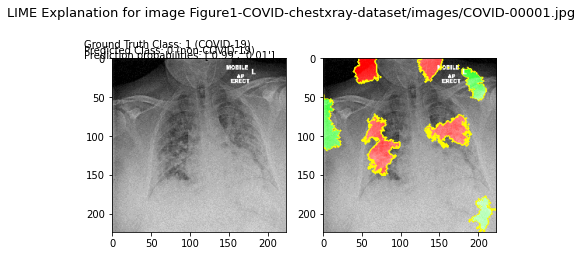

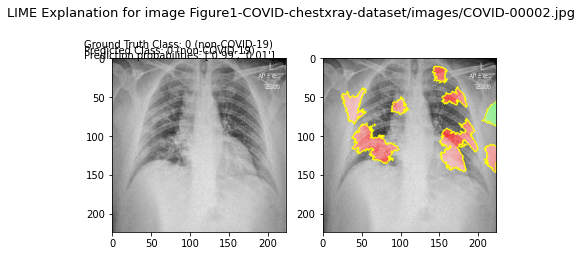

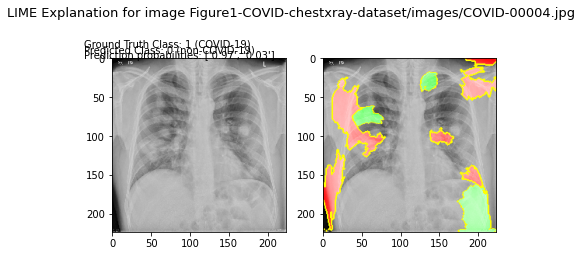

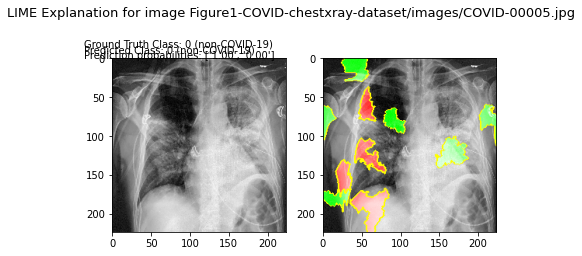

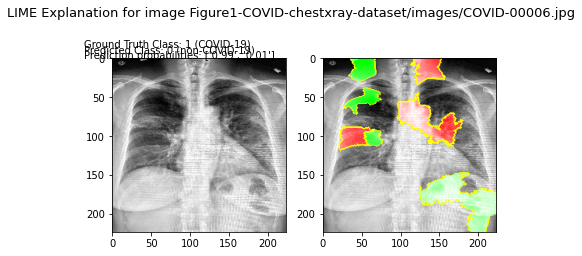

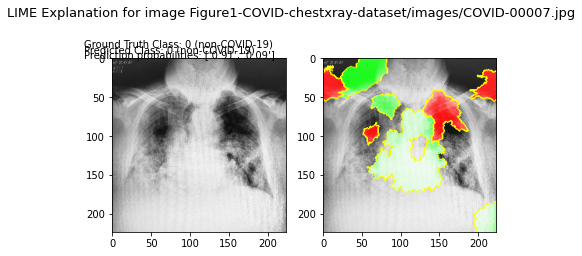

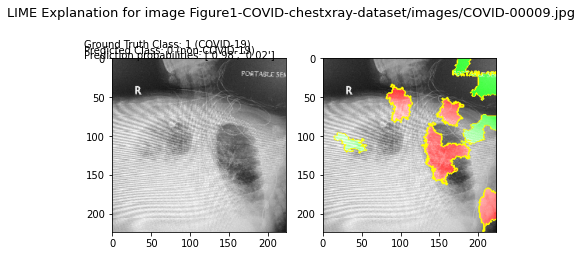

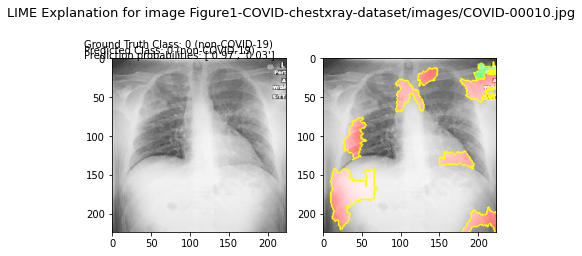

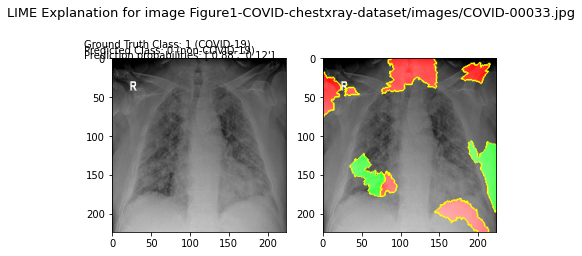

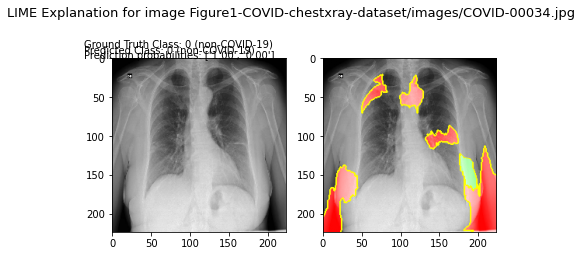

In [7]:
# Call the pre-defined LIME function 
# Import the images

if __name__ == '__main__':
    lime_dict = setup_lime()
    explain_xray(lime_dict, 182, save_exp=True) # 182, 00001, covid, index is from 0. Check the image from test.csv
    explain_xray(lime_dict, 183, save_exp=True) # 183，00002, non-covid, index is from 0. Check the image from test.csv
    explain_xray(lime_dict, 184, save_exp=True) # 184, 00004, covid， index is from 0. Check the image from test.csv
    explain_xray(lime_dict, 185, save_exp=True) # 185，00005, non-covid, index is from 0. Check the image from test.csv
    explain_xray(lime_dict, 186, save_exp=True) # 186, 00006, covid, index is from 0. Check the image from test.csv
    explain_xray(lime_dict, 187, save_exp=True) # 187，00007, non-covid, index is from 0. Check the image from test.csv
    explain_xray(lime_dict, 188, save_exp=True) # 188, 00009, covid， index is from 0. Check the image from test.csv
    explain_xray(lime_dict, 189, save_exp=True) # 189，00010, non-covid, index is from 0. Check the image from test.csv
    explain_xray(lime_dict, 190, save_exp=True) # 190, 00033, covid， index is from 0. Check the image from test.csv
    explain_xray(lime_dict, 191, save_exp=True) # 191，00034, non-covid, index is from 0. Check the image from test.csv


# Credits #


1.   https://arxiv.org/pdf/1602.04938.pdf
2.   https://github.com/aildnont/covid-cxr



